In [3]:
from cobra.io import load_matlab_model, read_sbml_model
from cobra import Reaction, Metabolite
import sys
import os
path = "F:\python\Bayesian_python_ecmodel"
os.chdir(path)
import matplotlib.pyplot as plt
import seaborn as sns
import cobra
import scipy.io as scio
# import self function
from src.mainFunction import *
from src.protein_process import *
from src.model_process import *
from src.constrain_ecmodel import *
from src.code_generation_preparation import *

In [4]:
import os
path = "F:\python\Bayesian_python_ecmodel"
os.chdir (path)
#load the dl_model
enzymedataFile = "data/model/Saccharomyces_cerevisiae_dl.mat"
z = scio.loadmat(enzymedataFile)
model = z['model'][0,0]
enzymedata = z['enzymedata'][0,0]
#scio.savemat('data/model/model.mat', {'model': model})
model_cobra = load_matlab_model('data/model/model.mat')

#construnct ecModel
#kcat_tmp = pd.read_csv("data/kcat_genra4.txt",delimiter=",",header=None)
kcat_tmp = pd.read_csv("data/kcat_genra100.txt",delimiter=",",header=None)
kcat_tmp = np.array(kcat_tmp)
kcat_100 = kcat_tmp[0:-2,:]
[a,b] = updateprior(kcat_100)
enzymedata['kcat'] = np.transpose(a)
enzymedata['kcat_var'] = np.transpose(b)
kcat_dict = construct_kcat_dict(model,enzymedata)
eModel = convertToEnzymeModel(model_cobra,kcat_dict)
MWs = construct_MWs(enzymedata)

#without proteomic data (initial version)
with eModel:
    ecModel = constrainPool(eModel, MWs, {}, eModel.enzymes, 230)
    s2 = get_r_max(ecModel,model_cobra)
    print("growth rate: ", s2.objective_value)
    print("Protein_pool: ", ecModel.reactions.get_by_id("prot_pool_exchange").upper_bound)

#exchange reactions
ex_mets = ['biomass pseudoreaction', 'D-glucose exchange', 'acetate exchange', 'ethanol exchange',
           'glycerol exchange', 'pyruvate exchange', 'ethyl acetate exchange', 'carbon dioxide exchange',
           'oxygen exchange', 'prot_pool_exchange']
# find the related rxnID
idx = []
for name0 in ex_mets:
   #print(name0)
    s = getRxnByReactionName(model=ecModel, name=name0)
    if len(s) > 1:
        print("need check")
    elif len(s) == 1:
        idx.append(s[0])

No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, ce, e, er, erm, g, gm, lp, m, mm, n, p, v, vm


Number of enzymes: 1131
Read LP format model from file C:\Users\sherr\AppData\Local\Temp\tmpkn08pg23.lp
Reading time = 0.03 seconds
: 3873 rows, 14678 columns, 59128 nonzeros
growth rate:  0.08409871417746716
Protein_pool:  230


In [5]:
genes, rxnIDs = zip(*kcat_dict.keys())
kcat_values = list(kcat_dict.values())

# 创建DataFrame
kcat_list = pd.DataFrame({
    'gene': genes,
    'rxnID': rxnIDs,
    'kcat': kcat_values
})
kcat_list

,gene,rxnID,kcat
0,YDL174C,r_0001_1,205871.114106
1,YEL039C,r_0001_1,102935.557053
2,YDL174C,r_0001_2,15652.536522
3,YJR048W,r_0001_2,7826.268261
4,YEL039C,r_0001_3,498984.330581
...,...,...,...
4349,YMR011W,p_5228_13_rvs,3071.609093
4350,YNR072W,p_5228_14_fwd,4246.904882
4351,YNR072W,p_5228_14_rvs,5864.661101
4352,YOL156W,p_5228_15_fwd,3832.989711


In [6]:
#prepare proteomic data
scer_data = pd.read_excel('data/uniprotkb_Scer.xlsx', sheet_name= "Sheet0")
proteomics_data = pd.read_excel('data/proteomics_Nlim_all.xlsx',sheet_name='Sheet1')
proteo_df = proteomics_data.merge(scer_data[['Entry', 'Gene Names']], left_on='Accession', right_on='Entry', how='left')
prot_cols = [col for col in proteo_df.columns if col.startswith('prot.')]
proteo_df[prot_cols] = proteo_df[prot_cols].apply(lambda x: x * 10**-9)
eModel_genes = [gene.id for gene in eModel.genes]

#growth data
growthdata = pd.read_csv('data/proteomics_test.csv')
growthdata = growthdata.drop(columns=['qNitrogen (mmol/gDW h)'])
growthdata = np.array(growthdata)
growthdata_test = growthdata[0:7] #NH4+

gene_to_entry_mapping = {}
# find the protein id to each gene names (one to several)
for index, row in scer_data.iterrows():
    entry = row['Entry']
    gene_names = row['Gene Names'].split()
    for gene in gene_names: gene_to_entry_mapping[gene] = entry

eModel_genes_series = pd.DataFrame(eModel_genes,columns=['emodel_genes'])
eModel_genes_series['entry_to_gene'] = eModel_genes_series['emodel_genes'].map(gene_to_entry_mapping)
proteo_df = proteo_df.merge(eModel_genes_series[['emodel_genes', 'entry_to_gene']], left_on='Accession', right_on='entry_to_gene', how='inner')
proteo_df.drop(['Accession','Gene','protein length','Entry','Gene Names'],axis = 1,inplace= True)

#update the kcat
ex_mets = ['biomass pseudoreaction', 'D-glucose exchange', 'acetate exchange', 'ethanol exchange',
               'glycerol exchange', 'pyruvate exchange', 'ethyl acetate exchange', 'carbon dioxide exchange',
              'oxygen exchange', 'prot_pool_exchange']
# find the related rxnID
idx = []
for name0 in ex_mets:
    s = getRxnByReactionName(model=eModel, name=name0)
    if len(s) > 1:
        print("need check")
    elif len(s) == 1:
        idx.append(s[0])



D:\Anaconda\lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [8]:
import os
path = "F:\python\Bayesian_python_ecmodel"
os.chdir (path)
geneID_all = {}
geneID_0 = {}
start = time.time()
toy_data = pd.DataFrame(columns=['error', 'corr', 'ss'])
for j in range(1) :
    if j % 100 == 0:
        print(f'current set processed: {j}')

    index = 'kcat_value'+str(j)
    toy_data_tmp = pd.DataFrame(columns=['error', 'corr', 'ss'])
    for i in range(len(growthdata_test)) :
        dilutionrate = growthdata_test[i,0]
        with ecModel as model_tmp:
            model_tmp = changeMedia (model , model_tmp , 'D-glucose' , "MIN")
            #model_tmp.reactions.get_by_id ('r_1634').bounds = 0 , 0
            model_tmp.reactions.get_by_id ('r_1631').bounds = 0 , 0
            model_tmp.reactions.get_by_id ('r_1761').upper_bound = 1000
            model_tmp.reactions.get_by_id ('r_1714').lower_bound = -growthdata_test[i , 1] #D-glucose exchange
            model_tmp.reactions.get_by_id("r_1654").bounds = -growthdata_test[i,-4],0 #NH4 exchange
            model_tmp.reactions.get_by_id("prot_pool_exchange").upper_bound = growthdata_test[i,9]*1000

            #print(model_tmp.optimize().objective_value)

            # minimize the usage of protein pools
            model_tmp.objective = {model_tmp.reactions.prot_pool_exchange: 1}
            solution_f = model_tmp.optimize()
            flux_max = solution_f.fluxes
            result = pd.DataFrame({'rxnID':flux_max.index, 'flux':flux_max.values})
            result = result[result['rxnID'].str.contains("prot_")]
            result['geneID'] = result['rxnID'].str.replace("draw_prot_", "")

            #compare with abundance
            abundance = pd.DataFrame()
            column_names = [f'prot.{3*i+1}',f'prot.{3*i+2}',f'prot.{3*i+3}']
            column_name = f'abundance{i+1}'
            abundance[column_name] = proteo_df[column_names].mean(axis=1)
            abundance1 = pd.concat([abundance,proteo_df['emodel_genes']],axis=1)
            result['pro_measured'] = singleMapping(abundance1[f"abundance{i+1}"],abundance1["emodel_genes"],result['geneID'])
            result = result[~result["pro_measured"].isna()]
            geneID_0_tmp = result[result['flux']==0]['geneID']
            geneID_0[f'flux{i}'] = geneID_0_tmp

            #pearsonr & pvalue
            from scipy.stats import pearsonr
            result1 = result[result['flux'] > 0]
            result1 = result1[result1['pro_measured'] > 0]

            corr, ss = pearsonr(np.log10(result1['pro_measured']), np.log10(result1['flux']))
            #print("Correlation coefficient:", corr)
            #print("Correlation p_value:", ss)

            #pro_evaluation
            result1['calculated'] = abs(((result1['flux'] - result1['pro_measured']) / result1['pro_measured']))**2
            filtered_geneIDs = result1[result1['calculated']>1000]['geneID']
            print(i)
            print(result1[result1['calculated']>1000])
            geneID_all[f'bad_protein{i}'] = filtered_geneIDs

            error = np.sqrt(result1['calculated'].sum()/len(result1['calculated']))

            toy_data_tmp.loc[i] = [error, corr, ss]
            print(toy_data_tmp)
    toy_data.loc[j] = [toy_data_tmp['error'].mean(),toy_data_tmp['corr'].mean(),toy_data_tmp['ss'].mean()]

#toy_data.to_csv('data/gan_input/pro_data1.csv', index=False)

end = time.time()
print(f'PROCESSING DONE in {end - start:.05} seconds')

current set processed: 0
0
                  rxnID      flux   geneID  pro_measured    calculated
6354  draw_prot_YOR065W  0.000006  YOR065W  7.996439e-08  5.192408e+03
6363  draw_prot_YOR283W  0.000014  YOR283W  6.357260e-08  4.797582e+04
6454  draw_prot_YOR273C  0.000393  YOR273C  1.673608e-08  5.509766e+08
6612  draw_prot_YMR145C  0.001024  YMR145C  9.259068e-07  1.222066e+06
6621  draw_prot_YJR051W  0.000001  YJR051W  2.206699e-08  2.551213e+03
6692  draw_prot_YMR250W  0.000006  YMR250W  3.931368e-09  2.666087e+06
6831  draw_prot_YKL217W  0.000030  YKL217W  9.625831e-08  9.691328e+04
7260  draw_prot_YKL174C  0.000246  YKL174C  7.000052e-10  1.236911e+11
          error      corr        ss
0  43387.978682 -0.309685  0.011394
1
                  rxnID          flux   geneID  pro_measured    calculated
6264  draw_prot_YBR006W  3.572700e-06  YBR006W  1.371031e-08  6.738434e+04
6334  draw_prot_YEL024W  3.311538e-05  YEL024W  2.904617e-07  1.277114e+04
6354  draw_prot_YOR065W  3.311538e-

In [9]:
geneID_df = pd.DataFrame(dict([(k,pd.Series(v)) for k,v in geneID_all.items()]))
geneID0_df = pd.DataFrame(dict([(k,pd.Series(v)) for k,v in geneID_0.items()]))
geneID0_df

,flux0,flux1,flux2,flux3,flux4,flux5,flux6
6208,YJL126W,YJL126W,YJL126W,YJL126W,YJL126W,YJL126W,YJL126W
6209,YDR135C,YDR135C,YDR135C,YDR135C,YDR135C,YDR135C,YDR135C
6212,YDR373W,YDR373W,YDR373W,YDR373W,YDR373W,YDR373W,YDR373W
6214,YER043C,YER043C,YER043C,YER043C,YER043C,YER043C,YER043C
6215,YKL029C,YKL029C,YKL029C,YKL029C,YKL029C,YKL029C,YKL029C
...,...,...,...,...,...,...,...
7323,YIR036C,YIR036C,YIR036C,YIR036C,YIR036C,YIR036C,YIR036C
7325,YOR321W,YOR321W,YOR321W,YOR321W,YOR321W,YOR321W,YOR321W
7326,YDR111C,YDR111C,YDR111C,YDR111C,YDR111C,YDR111C,YDR111C
7329,YEL041W,YEL041W,YEL041W,YEL041W,YEL041W,YEL041W,YEL041W


In [10]:
geneID_0

{'flux0': 6208    YJL126W
 6209    YDR135C
 6212    YDR373W
 6214    YER043C
 6215    YKL029C
          ...   
 7323    YIR036C
 7325    YOR321W
 7326    YDR111C
 7329    YEL041W
 7333    YNL277W
 Name: geneID, Length: 689, dtype: object,
 'flux1': 6208    YJL126W
 6209    YDR135C
 6212    YDR373W
 6214    YER043C
 6215    YKL029C
          ...   
 7323    YIR036C
 7325    YOR321W
 7326    YDR111C
 7329    YEL041W
 7333    YNL277W
 Name: geneID, Length: 689, dtype: object,
 'flux2': 6208    YJL126W
 6209    YDR135C
 6212    YDR373W
 6214    YER043C
 6215    YKL029C
          ...   
 7323    YIR036C
 7325    YOR321W
 7326    YDR111C
 7329    YEL041W
 7333    YNL277W
 Name: geneID, Length: 688, dtype: object,
 'flux3': 6208    YJL126W
 6209    YDR135C
 6212    YDR373W
 6214    YER043C
 6215    YKL029C
          ...   
 7323    YIR036C
 7325    YOR321W
 7326    YDR111C
 7329    YEL041W
 7333    YNL277W
 Name: geneID, Length: 688, dtype: object,
 'flux4': 6208    YJL126W
 6209    YDR135C
 

In [11]:
import pandas as pd

# 假设 geneID_df 是您的 DataFrame
# geneID_df = ...

# 将 DataFrame 转换为长格式
long_format = geneID_df.melt(var_name='columns', value_name='geneID')

# 获取所有非空的 geneID 值
geneID_list = long_format['geneID'].dropna().unique().tolist()

# geneID_list 现在包含了 DataFrame 中所有唯一的非空元素
geneID_list

['YOR065W',
 'YOR283W',
 'YOR273C',
 'YMR145C',
 'YJR051W',
 'YMR250W',
 'YKL217W',
 'YKL174C',
 'YBR006W',
 'YEL024W',
 'YPL271W',
 'YGR019W',
 'YDR178W',
 'YHR116W',
 'YEL047C',
 'YIL155C',
 'YOR303W',
 'YDL066W',
 'YOL059W',
 'YKL120W',
 'YKL141W',
 'YKR039W',
 'YDR231C',
 'YHL032C']

In [12]:
result3 = {k: v for k, v in kcat_dict.items() if k[0] in geneID_list}
result3

{('YGR019W', 'r_0068'): 2859.3789730907,
 ('YPL271W', 'r_0226_1'): 5781961.125272799,
 ('YPL271W', 'r_0226_2'): 25716848.402646635,
 ('YPL271W', 'r_0226_3'): 11411339.283403987,
 ('YOR303W', 'r_0250'): 53267.70336454545,
 ('YDR231C', 'r_0438_5'): 1714948.728747704,
 ('YHR116W', 'r_0438_5'): 1714948.728747704,
 ('YEL024W', 'r_0439_1'): 61662.89203137307,
 ('YOR065W', 'r_0439_1'): 61662.89203137307,
 ('YEL024W', 'r_0439_2'): 127981.90869660105,
 ('YOR065W', 'r_0439_2'): 127981.90869660105,
 ('YEL047C', 'r_0454_fwd'): 32738.635143550608,
 ('YEL047C', 'r_0454_rvs'): 3100.111239723612,
 ('YEL047C', 'r_0455_fwd'): 23536.265354848758,
 ('YEL047C', 'r_0455_rvs'): 2554.429747306498,
 ('YMR250W', 'r_0469'): 2657.6627917653477,
 ('YHL032C', 'r_0488'): 916.7788796363732,
 ('YIL155C', 'r_0490'): 3945.3494297898574,
 ('YOL059W', 'r_0491_2'): 166954.87310920426,
 ('YOL059W', 'r_0492'): 24922.014084482442,
 ('YMR145C', 'r_0770_2'): 596.5073671277802,
 ('YOR283W', 'r_0893_1_fwd'): 43688.08353353732,
 (

In [19]:
data = pd.read_csv('data/RMSE2.csv')
enzyme_preparation = data[data['ERROR']<0.05]
enzyme_preparation

,gene,rxnID,RMSE,ERROR
0,YDL174C,r_0001_1,2.693123,1.369550e-09
1,YOL086C,r_0166_3,2.693123,1.369550e-09
2,YDR001C,r_0194,2.693123,1.369550e-09
3,YPL271W,r_0226_1,2.693123,1.369550e-09
4,YKL019W,r_0249,2.693123,1.369550e-09
...,...,...,...,...
1146,YOR040W,r_0554,2.826776,4.962744e-02
1147,YDL142C,r_2553,2.559275,4.970020e-02
1148,YJR001W,r_1187,2.559085,4.977068e-02
1149,YKR067W,r_2321,2.827286,4.981659e-02


In [23]:
kcat_df = pd.DataFrame(list(kcat_dict.items()), columns=['gene_rxnID', 'kcat_value'])
kcat_df[['gene', 'rxnID']] = pd.DataFrame(kcat_df['gene_rxnID'].tolist(), index=kcat_df.index)
merged_df = pd.merge(enzyme_preparation, kcat_df, on=['gene', 'rxnID'])
kcat_final = merged_df[['gene', 'rxnID', 'kcat_value']]
kcat_final

,gene,rxnID,kcat_value
0,YDL174C,r_0001_1,2.058711e+05
1,YOL086C,r_0166_3,2.683236e+05
2,YDR001C,r_0194,3.549088e+04
3,YPL271W,r_0226_1,5.781961e+06
4,YKL019W,r_0249,1.183375e+04
...,...,...,...
1146,YOR040W,r_0554,5.347120e+05
1147,YDL142C,r_2553,2.562923e+04
1148,YJR001W,r_1187,5.362503e+03
1149,YKR067W,r_2321,4.625717e+03


In [25]:
import pandas as pd

# 将字典的键和值分别分解为列表
genes, rxnIDs, values = zip(*[(k[0], k[1], v) for k, v in result.items()])

# 创建 DataFrame
df = pd.DataFrame({
    'gene': genes,
    'rxnID': rxnIDs,
    'kcat_value': values
})
df


,gene,rxnID,kcat_value
0,YJR048W,r_0001_2,7.826268e+03
1,YJR048W,r_0001_4,3.402109e+05
2,YJR048W,r_0002_2,2.763305e+03
3,YJR048W,r_0004_2,1.248751e+06
4,YCR034W,r_0005_3,1.089534e+05
...,...,...,...
128,YKL069W,r_4202_fwd,5.660458e+04
129,YKL069W,r_4202_rvs,8.435476e+03
130,YJR051W,r_4264,9.010885e+04
131,YOR374W,r_4678_3_fwd,7.523925e+03


In [26]:
import pandas as pd

# 假设 df 和 kcat_final 是已经定义的两个 DataFrame

# 使用 merge 方法合并这两个 DataFrame
# on 参数指定了用于合并的列
merged_df = pd.merge(df, kcat_final, on=['gene', 'rxnID'])

merged_df


,gene,rxnID,kcat_value_x,kcat_value_y
0,YJR048W,r_0001_2,7.826268e+03,7.826268e+03
1,YJR048W,r_0002_2,2.763305e+03,2.763305e+03
2,YCR034W,r_0005_3,1.089534e+05,1.089534e+05
3,YDR127W,r_0039,3.779265e+04,3.779265e+04
4,YHR163W,r_0091_2,1.725324e+04,1.725324e+04
5,YOR374W,r_0176,6.115438e+03,6.115438e+03
6,YPL271W,r_0226_1,5.781961e+06,5.781961e+06
7,YLR304C,r_0280_rvs,2.054705e+05,2.054705e+05
8,YLR304C,r_0302_rvs,7.561961e+06,7.561961e+06
9,YJR048W,r_0437_2,2.764166e+05,2.764166e+05


In [27]:
merged_df.to_csv('data/merged_data.csv', index=False)


In [13]:
datatmp = np.load("F:/python/Bayesian_python_ecmodel/gan_output/toy/repeat_0/990_r.npy")
datatmp

array([[ 6.752368 ,  8.788536 , 18.458477 , ..., 11.488022 ,  5.6801147,
         8.159556 ],
       [ 7.458447 ,  7.906539 , 10.809877 , ...,  9.250497 ,  7.7042594,
         4.645067 ],
       [ 8.430286 , 12.697377 , 11.953907 , ...,  9.578655 ,  4.684979 ,
         6.099497 ],
       ...,
       [ 9.324055 , 10.372627 , 11.582275 , ...,  9.059173 ,  7.4651513,
        15.331405 ],
       [ 8.693874 , 10.278271 ,  8.940292 , ...,  7.5732536,  4.96465  ,
         9.619839 ],
       [ 8.168481 ,  6.4152575, 15.693808 , ...,  8.914507 ,  6.9465623,
         9.77699  ]], dtype=float32)

In [11]:
        dilutionrate = 0.8
        with ecModel as model_tmp:


            #phenotype in PNAS2021
            model_tmp.reactions.r_1714.lower_bound = -20
            model_tmp.reactions.r_1634.lower_bound = 0.566
            model_tmp.reactions.r_1761.lower_bound = 27
            model_tmp.reactions.r_1808.lower_bound = 1.469
            print(model_tmp.optimize().objective_value)

            #model_tmp.reactions.get_by_id(idx[1]).lower_bound = -1000  # glucose uptake
            model_tmp.reactions.get_by_id(idx[0]).lower_bound = dilutionrate
            model_tmp.objective = {model_tmp.reactions.r_1714: 1}  # minimize the uptake of glucose
            solution2 = model_tmp.optimize()
            print(solution2.objective_value)

            try:
            # then fix glucose uptake and minimize the protein pool
                model_tmp.reactions.get_by_id(idx[1]).lower_bound = solution2.objective_value * 1.00001
                print('Glucose uptake rate: ',solution2.objective_value)
            except TypeError:
                print("Error")

0.4741984587066539
None
Error


D:\Anaconda\lib\site-packages\cobra\util\solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


In [ ]:
dilutionrate = 0.42
correlation_coef = {}
foldchanges = [0, 0.9, 1.1, 1.5]
for foldchange in foldchanges:
    Correlation_coefficient = []
    for index, row in kcat_list.iterrows():
        with ecModel as model_tmp:
            #change each kcat in each reaction
            target_gene0 = row['gene']
            kcat_m0 = row['kcat']*foldchange
            rxn0 = row['rxnID']
            model_tmp = updateEcGEMkcat(ecGEM=model_tmp, target_gene=target_gene0, rxnID=rxn0, kcat_m=kcat_m0)

            #phenotype in PNAS2021
            model_tmp.reactions.r_1714.lower_bound = -20
            model_tmp.reactions.r_1634.lower_bound = 0.566
            model_tmp.reactions.r_1761.lower_bound = 27
            model_tmp.reactions.r_1808.lower_bound = 1.469
            print(model_tmp.optimize().objective_value)
            #model_tmp.reactions.get_by_id(idx[1]).lower_bound = -1000  # glucose uptake
            model_tmp.reactions.get_by_id(idx[0]).lower_bound = dilutionrate
            model_tmp.objective = {model_tmp.reactions.r_1714: 1}  # minimize the uptake of glucose
            solution2 = model_tmp.optimize()
            print(solution2.objective_value)
            # then fix glucose uptake and minimize the protein pool
            model_tmp.reactions.get_by_id(idx[1]).lower_bound = solution2.objective_value * 1.00001
            print('Glucose uptake rate: ',solution2.objective_value)
            model_tmp.reactions.get_by_id(idx[9]).lower_bound = -1000 # protein pool
            model_tmp.objective = {model_tmp.reactions.prot_pool_exchange: 1}  # minimize the usage of protein pools
            solution_f = model_tmp.optimize()

            #
            flux_max = solution_f.fluxes
            result = pd.DataFrame({'rxnID':flux_max.index, 'flux':flux_max.values})
            result = result[result['rxnID'].str.contains("prot_")]
            result['geneID'] = result['rxnID'].str.replace("draw_prot_", "")
            # input the proteomics under max growth rate
            abundance_ex = pd.read_excel("data/proteomics/data_PNAS_2021.xlsx")
            abundance_ex['g/gDW'] =(abundance_ex['replicate 1 (g gDW-1)']+ abundance_ex['replicate 2 (g gDW-1)']+ abundance_ex['replicate 3 (g gDW-1)'])/3
            abundance_ex=abundance_ex[['Symbol','g/gDW']]
            abundance_ex.columns = ['gene','g/gDW']
            abundance_ex1 = splitAbundance(pro_df=abundance_ex)
            # change the unit from g/gDW as mmol/gDW
            # input the molecular weight
            mw = pd.read_csv("data/sce_protein_weight.tsv", sep="\t")
            mw = mw[["locus","proteins_molecular_weight"]]
            mw.columns = ["gene name", "MW"]
            mw["MW_Kda"] = mw["MW"]/1000
            abundance_ex1["MW_Kda"] = singleMapping(mw["MW_Kda"], mw["gene name"], abundance_ex1["gene"])
            abundance_ex_check = abundance_ex1[abundance_ex1["MW_Kda"].isna()]
            abundance_ex1=abundance_ex1[~abundance_ex1["MW_Kda"].isna()]
            abundance_ex1["mmol/gDW"] = abundance_ex1["g/gDW"]/abundance_ex1["MW_Kda"]# #mmol/g biomass

            result['pro_measured'] = singleMapping(abundance_ex1["mmol/gDW"],abundance_ex1["gene"],result['geneID'])
            result = result[~result["pro_measured"].isna()]
            result.to_excel("data/data_check.xlsx")

            # change the protein abundance unit from mmol/gDW into protein copy/cell
            coefficient1 = 7.8298e9
            result_unify = result.copy()
            result_unify["pro_measured"] = result['pro_measured']*coefficient1
            result_unify["flux"] = result['flux']*coefficient1

            from scipy.stats import pearsonr
            result1 = result[result['flux'] > 0]
            result1 = result1[result1['pro_measured'] > 0]
            corr, ss = pearsonr(np.log10(result1['pro_measured']), np.log10(result1['flux']))
            Correlation_coefficient.append(corr)
            print("Correlation coefficient:", corr)
            print("Correlation p_value:", ss)
#for foldchange in foldchanges:
    correlation_coef_df = pd.DataFrame({
        'gene': genes,
        'rxnID': rxnIDs,
        'Correlation_coefficient': Correlation_coefficient
    })
    correlation_coef["correlation_coef_{0}".format(foldchange)] = correlation_coef_df

Read LP format model from file C:\Users\sherr\AppData\Local\Temp\tmpe61cdmn9.lp
Reading time = 0.04 seconds
: 3874 rows, 14680 columns, 61392 nonzeros
old coefficient 4.857408016391145e-06 YDL174C[c]
old kcat 205871.11410561696
new coefficient 3.2382720109274302e-06 YDL174C[c]
new kcat 308806.67115842545
old rxn: 4.857408016391145e-06 YDL174C[c] + 9.71481603278229e-06 YEL039C[c] + s_0025[c] + 2.0 s_0709[m] --> 2.0 s_0710[m] + s_1399[c]
new rxn: 3.2382720109274302e-06 YDL174C[c] + 9.71481603278229e-06 YEL039C[c] + s_0025[c] + 2.0 s_0709[m] --> 2.0 s_0710[m] + s_1399[c]
0.47419845870665495
-18.147190350558805
Glucose uptake rate:  -18.147190350558805
Mutiple protein have one abudance value! Need quality check.
56 gene     YBR009C; YNL030W
g/gDW            0.000348
Name: 56, dtype: object
63 gene     YPR080W; YBR118W
g/gDW            0.020647
Name: 63, dtype: object
276 gene     YKR059W; YJL138C
g/gDW            0.001259
Name: 276, dtype: object
890 gene     YOR133W; YDR385W
g/gDW        

Exception ignored in: <function ZipFile.__del__ at 0x000001BC9E4BE310>
Traceback (most recent call last):
  File "D:\Anaconda\lib\zipfile.py", line 1816, in __del__
    self.close()
KeyboardInterrupt: 


KeyboardInterrupt: 

In [33]:
   #model_tmp = ecModel.copy() # this is adjusted for the newly added constraints from organelle
dilutionrate = 0.42
with ecModel as model_tmp:
    model_tmp.reactions.r_1714.lower_bound = -20
    model_tmp.reactions.r_1634.lower_bound = 0.566
    model_tmp.reactions.r_1761.lower_bound = 27
    model_tmp.reactions.r_1808.lower_bound = 1.469
    print(model_tmp.optimize().objective_value)
    #model_tmp.reactions.get_by_id(idx[1]).lower_bound = -1000  # glucose uptake
    model_tmp.reactions.get_by_id(idx[0]).lower_bound = dilutionrate
    model_tmp.objective = {model_tmp.reactions.r_1714: 1}  # minimize the uptake of glucose
    solution2 = model_tmp.optimize()
    print(solution2.objective_value)
    # then fix glucose uptake and minimize the protein pool
    model_tmp.reactions.get_by_id(idx[1]).lower_bound = solution2.objective_value * 1.00001
    print('Glucose uptake rate: ',solution2.objective_value)
    model_tmp.reactions.get_by_id(idx[9]).lower_bound = -1000 # protein pool
    model_tmp.objective = {model_tmp.reactions.prot_pool_exchange: 1}  # minimize the usage of protein pools
    solution_f = model_tmp.optimize()
    print(solution_f.fluxes["prot_pool_exchange"])
    print(solution_f.fluxes["r_1714"])

0.5706100853164073
-18.144956388662784
Glucose uptake rate:  -18.144956388662784
230.0
-18.144956388662784


Mutiple protein have one abudance value! Need quality check.
56 gene     YBR009C; YNL030W
g/gDW            0.000348
Name: 56, dtype: object
63 gene     YPR080W; YBR118W
g/gDW            0.020647
Name: 63, dtype: object
276 gene     YKR059W; YJL138C
g/gDW            0.001259
Name: 276, dtype: object
890 gene     YOR133W; YDR385W
g/gDW            0.004732
Name: 890, dtype: object
2808 gene     YBR010W; YNL031C
g/gDW            0.000498
Name: 2808, dtype: object
Complete the quality check!
Correlation coefficient: 0.48554064778103573
Correlation p_value: 4.851332772897612e-21


D:\Anaconda\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Text(0, 0.5, 'Predicted_protein_copy/cell')

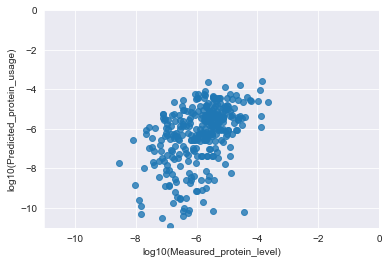

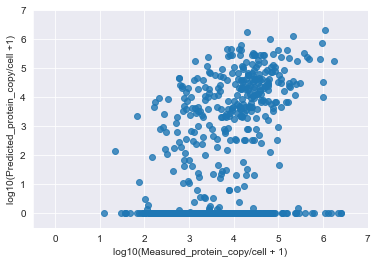

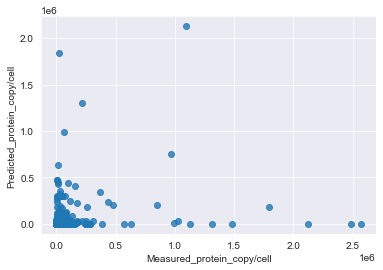

In [34]:
flux_max = solution_f.fluxes
result = pd.DataFrame({'rxnID':flux_max.index, 'flux':flux_max.values})
result = result[result['rxnID'].str.contains("prot_")]
result['geneID'] = result['rxnID'].str.replace("draw_prot_", "")
# input the proteomics under max growth rate
abundance_ex = pd.read_excel("data/proteomics/data_PNAS_2021.xlsx")
abundance_ex['g/gDW'] =(abundance_ex['replicate 1 (g gDW-1)']+ abundance_ex['replicate 2 (g gDW-1)']+ abundance_ex['replicate 3 (g gDW-1)'])/3
abundance_ex=abundance_ex[['Symbol','g/gDW']]
abundance_ex.columns = ['gene','g/gDW']
abundance_ex1 = splitAbundance(pro_df=abundance_ex)
# change the unit from g/gDW as mmol/gDW
# input the molecular weight
mw = pd.read_csv("data/sce_protein_weight.tsv", sep="\t")
mw = mw[["locus","proteins_molecular_weight"]]
mw.columns = ["gene name", "MW"]
mw["MW_Kda"] = mw["MW"]/1000
abundance_ex1["MW_Kda"] = singleMapping(mw["MW_Kda"], mw["gene name"], abundance_ex1["gene"])
abundance_ex_check = abundance_ex1[abundance_ex1["MW_Kda"].isna()]
abundance_ex1=abundance_ex1[~abundance_ex1["MW_Kda"].isna()]
abundance_ex1["mmol/gDW"] = abundance_ex1["g/gDW"]/abundance_ex1["MW_Kda"]# #mmol/g biomass

result['pro_measured'] = singleMapping(abundance_ex1["mmol/gDW"],abundance_ex1["gene"],result['geneID'])
result = result[~result["pro_measured"].isna()]
result.to_excel("data/data_check.xlsx")

# change the protein abundance unit from mmol/gDW into protein copy/cell
coefficient1 = 7.8298e9
result_unify = result.copy()
result_unify["pro_measured"] = result['pro_measured']*coefficient1
result_unify["flux"] = result['flux']*coefficient1

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr

# method1 absolute protein abundance mmol protein/gDW
plt.figure()
sns.regplot(x=np.log10(result['pro_measured']), y=np.log10(result['flux']), fit_reg=False)
plt.xlim(-11, 0)
plt.ylim(-11, 0)
plt.xlabel("log10(Measured_protein_level)")
plt.ylabel("log10(Predicted_protein_usage)")

from scipy.stats import pearsonr
result1 = result[result['flux'] > 0]
result1 = result1[result1['pro_measured'] > 0]
corr, ss = pearsonr(np.log10(result1['pro_measured']), np.log10(result1['flux']))
print("Correlation coefficient:", corr)
print("Correlation p_value:", ss)


# method2 protein copy/cell
plt.figure()
sns.regplot(x=np.log10(result_unify['pro_measured']+1), y=np.log10(result_unify['flux']+1), fit_reg=False)
plt.xlim(-0.5, 7)
plt.ylim(-0.5, 7)
plt.xlabel("log10(Measured_protein_copy/cell + 1)")
plt.ylabel("log10(Predicted_protein_copy/cell +1)")

plt.figure()
sns.regplot(x=result_unify['pro_measured'], y=result_unify['flux'], fit_reg=False)
plt.xlabel("Measured_protein_copy/cell")
plt.ylabel("Predicted_protein_copy/cell")

In [41]:
result['calculated'] = abs(((result['flux'] - result['pro_measured']) / result['pro_measured']))**2
filtered_df = result[(result['calculated'] > 10000) | (result['calculated'] < 0.0001) | (result['calculated'] == 1)]
#filtered_df = result[(result['calculated'] > 10000) ]
len(filtered_df)

530

In [32]:
for index, row in filtered_df.iterrows():
    target_gene0 = row['geneID']
    kcat_m0 = 1 / row['pro_measured']
    print(target_gene0)
    print(kcat_m0)
    # 从模型中获取相关的反应ID
    rxnID = getRxnByGene(model=ecModel, gene0=target_gene0+'[c]')
    rxnID = [item for item in rxnID if not item.startswith('draw_prot_')]
    print(rxnID)

    # 对于每个反应ID，更新模型参数
    for rxn0 in rxnID:
        ecModel = updateEcGEMkcat(ecGEM=ecModel, target_gene=target_gene0, rxnID=rxn0, kcat_m=kcat_m0)

YLR174W
53616162.2845674
['r_0659_fwdNo1', 'r_0659_rvsNo1']
Read LP format model from file C:\Users\sherr\AppData\Local\Temp\tmpuqjr_p9u.lp
Reading time = 0.03 seconds
: 3874 rows, 14680 columns, 61392 nonzeros
old coefficient 2.650602038956352e-05 YLR174W[c]
old kcat 37727.27800336787
new coefficient 1.8651092457765012e-08 YLR174W[c]
new kcat 53616162.2845674
old rxn: 2.650602038956352e-05 YLR174W[c] + s_0940[c] + s_1207[c] --> s_0180[c] + s_0456[c] + s_1212[c]
new rxn: 1.8651092457765012e-08 YLR174W[c] + s_0940[c] + s_1207[c] --> s_0180[c] + s_0456[c] + s_1212[c]
Read LP format model from file C:\Users\sherr\AppData\Local\Temp\tmp0zyehtnd.lp
Reading time = 0.03 seconds
: 3874 rows, 14680 columns, 61392 nonzeros
old coefficient 7.429940344572412e-06 YLR174W[c]
old kcat 134590.58264586233
new coefficient 1.8651092457765012e-08 YLR174W[c]
new kcat 53616162.2845674
old rxn: 7.429940344572412e-06 YLR174W[c] + s_0180[c] + s_0456[c] + s_1212[c] --> s_0940[c] + s_1207[c]
new rxn: 1.865109245

In [15]:
# manual curation 2
rxnID = getRxnByGene(model=ecModel, gene0='YGR183C[c]')
# using a loop
for rxn0 in rxnID:
    target_gene0 = 'YGR183C'
    kcat_m0 = 1/(9.229932e-8)
    ecYeast = updateEcGEMkcat(ecGEM=ecModel, target_gene=target_gene0, rxnID=rxn0, kcat_m=kcat_m0)

Read LP format model from file C:\Users\sherr\AppData\Local\Temp\tmpqld6xjpr.lp
Reading time = 0.03 seconds
: 3874 rows, 14680 columns, 61392 nonzeros
old coefficient 7.813604361618323e-06 YGR183C[c]
old kcat 127981.90869660105
new coefficient 9.229932e-08 YGR183C[c]
new kcat 10834316.00579506
old rxn: 7.813604361618323e-06 Q0105[c] + 7.813604361618323e-06 YBL045C[c] + 7.813604361618323e-06 YDR529C[c] + 7.813604361618323e-06 YEL024W[c] + 7.813604361618323e-06 YFR033C[c] + 7.813604361618323e-06 YGR183C[c] + 7.813604361618323e-06 YHR001W-A[c] + 7.813604361618323e-06 YJL166W[c] + 7.813604361618323e-06 YJR048W[c] + 7.813604361618323e-06 YOR065W[c] + 7.813604361618323e-06 YPR191W[c] + 2.0 s_0709[m] + 1.266 s_0799[m] + s_1535[m] --> 2.0 s_0710[m] + 2.532 s_0794[c] + s_1537[m]
new rxn: 7.813604361618323e-06 Q0105[c] + 7.813604361618323e-06 YBL045C[c] + 7.813604361618323e-06 YDR529C[c] + 7.813604361618323e-06 YEL024W[c] + 7.813604361618323e-06 YFR033C[c] + 9.229932e-08 YGR183C[c] + 7.813604361

In [14]:
2.33e-3

0.00233

In [5]:
    rxn_list2 = []
    gene0 = 'YGR183C[c]'
    for gene in ecModel.metabolites:
        if gene.id == gene0:
            rxn_list = gene.reactions
            for x in rxn_list:
                rxn_list2.append(x.id)
    rxn_list2[:-1]

['r_0439_2No1', 'r_0439_1No1']

In [2]:
def getRxnByGene(model, gene0):
    """
    :param model: A metabolic model
    :param gene0: A gene
    :return:

    Example:
    getRxnByGene(model, gene0="YGR192C")

    """
    rxn_list2 = []
    for gene in model.metabolites:
        if gene.id == gene0:
            rxn_list = gene.reactions
            for x in rxn_list:
                rxn_list2.append(x.id)
    return rxn_list2


In [27]:
def updateEcGEMkcat(ecGEM, target_gene, rxnID, kcat_m):
    """
    The function is used to update the kcat of enzyme in specific reaction from ecModel
    Generally, an enzyme and the related reaction determine the corresponding kcat value.

    :param ecGEM: the enzyme constrainted model
    :param target_gene: the gene id of the enzyme
    :param rxnID: the reaction id contains the enzyme
    :param kcat_m: the new value of kcat
    :return:
    ecModel

    """
    ecModel = ecGEM.copy()
    coef = 1 / kcat_m
    ss = ecModel.reactions.get_by_id(rxnID).reaction
    # split as coefficient
    ss1 = ss.split(" + ")
    ss2 = []
    for xx in ss1:
        if target_gene + '[' in xx:
            xx1 = xx.split(' ')[1]
            xx2 = str(coef) + ' ' + xx1
            print('old coefficient', xx)
            print('old kcat', 1 / float(xx.split(' ')[0]))
            print('new coefficient', xx2)
            print('new kcat', kcat_m)
            ss2.append(xx2)
        else:
            ss2.append(xx)
    rxn_update = " + ".join(ss2)
    print('old rxn:', ss)
    print('new rxn:', rxn_update)
    ecModel.reactions.get_by_id(rxnID).reaction = rxn_update
    return ecModel

In [37]:
import numpy as np
import os
import cobra
from pathlib import Path
from sklearn.metrics import mean_squared_error
import pandas as pd
from cobra.io import load_matlab_model , save_matlab_model , read_sbml_model , write_sbml_model
import scipy.io as scio
from scipy import sparse
import cobra.util
from cobra import Model , Reaction , Metabolite
import cProfile
import time
from multiprocessing import cpu_count , Manager , Process
from code_generation_preparation import changeMedia
from code_generation_preparation import anaerobicModel

def rmsecal(model , model_cobra , data , constrain , tot_prot_weight , rxn2block):
    data = np.array (data)
    rmse_tmp = []
    simulated = np.zeros ((len (data[: , 0]) , 9))
    rxnNames = model['rxnNames']
    for i in range (len (data[: , 0])):
        exp = np.array (data[: , 0:9])  # u sub ace eth gly pyr ethyl_acetate co2 o2
        exp = exp * [1 , -1 , 1 , 1 , 1 , 1 , 1 , 1 , -1]
        exp = exp.astype (np.float)
        ex_mets = ['growth' , "D-glucose exchange" , 'ethanol exchange' ,'acetate exchange' ,
                    'pyruvate exchange' , 'succinate exchange' ,'glycerol exchange' , 'carbon dioxide exchange' ,
                   'oxygen exchange']
        idx = []
        temp = []
        for k in range (len (ex_mets)):
            temp = np.where (rxnNames==ex_mets[k])
            idx.append (temp)
        idx = np.array (idx)
        idx = np.transpose (idx[: , 0])
        # Create a temp model
        start_time1 = time.time ()

        with model_cobra as model_tmp:

            # Suitable for different carbon sources
            #model_tmp = changeMedia (model , model_tmp , data[i , 1][0] , data[i , 15])  # 'D-glucose'
            model_tmp = changeMedia (model , model_tmp , 'D-glucose' , "MIN")
            model_tmp.reactions.get_by_id ('r_1634').bounds = 0 , 0
            model_tmp.reactions.get_by_id ('r_1631').bounds = 0 , 0

            model_tmp.reactions.get_by_id ('r_1714').lower_bound = 0

            id_substrate = np.where (model['rxnNames']==("D-glucose  exchange"))
            if constrain==False:
                model_tmp.reactions[idx[0][1]].lower_bound = -1000
            else:
                model_tmp.reactions[idx[0][1]].lower_bound = exp[i , 1]

            model_tmp.reactions.get_by_id("r_1654").upper_bound = data[i,11] #NH4 exchange
            model_tmp.reactions.get_by_id("r_1851").upper_bound = data[i,12] #L-glutamine exchange
            model_tmp.reactions.get_by_id("r_1903").upper_bound = data[i,13] #L-phenylalanine exchange
            model_tmp.reactions.get_by_id("r_1897").upper_bound = data[i,14] #L-isoleucine exchange



            model_tmp.reactions.get_by_id("prot_pool_exchange").upper_bound = data[i,9]*1000


            # Solve the temp model
            sol_tmp = model_tmp.optimize ()
            sol = sol_tmp.fluxes  # sol[:,i] = sol_tmp.fluxes

        print ("No. " + str (i + 1) + "finish !")

        tmp = np.where (~np.isnan (exp[i]))[0]

        # Normalize the number of carbon
        excarbon = model['excarbon'][: , idx[0]]
        for x in range (len (idx[0 , :])):
            if excarbon[: , x]==0:
                excarbon[: , x] = 1
        exp_tmp = []
        for s in range (len (tmp)):
            #exp_tmp.append (exp[i , tmp[s]] * excarbon[: , tmp[s]])
            exp_tmp.append (exp[i , tmp[s]])
        sol_idx = np.transpose (sol[idx[0]])
        sol_idx = np.array (sol_idx)
        simulated_tmp = []
        for t in range (len (tmp)):
            simulated_tmp.append (
                np.array (sol_idx)[tmp[t]] * excarbon[: , tmp[t]])  # normalize the growth rate issue by factor 10

        # The expected blocked reactions
        exp_block = np.zeros ((1 , 218))  # 218怎么替换
        rxnblockidx_pre = np.setdiff1d (rxn2block , model['rxns'][idx[0][1]])
        rxnblockidx = []
        for k in range (len (model['rxns'])):
            if model['rxns'][k] in rxnblockidx_pre:
                rxnblockidx.append (k)

        simulated_block = []
        for t in range (len (rxnblockidx)):
            simulated_block.append (np.array (sol)[rxnblockidx[t]] * model['excarbon'][: , rxnblockidx[t]])
        id_zero = np.where (np.array (simulated_block)!=0)
        exp_block = exp_block[: , id_zero[0]]
        simulated_block = np.array (simulated_block)[id_zero[0]]
        exp_tmp = np.array (exp_tmp)
        # print ("exp_tmp: " , exp_tmp)
        # print ("simulated_tmp: " , simulated_tmp)
        # print ("exp_block: " , exp_block)
        # print ("simulated_block: " , simulated_block)

        # Calculate the RMSE
        if constrain:
            rmse_tmp.append (np.sqrt (mean_squared_error (np.append (exp_tmp , np.transpose (exp_block)) ,
                                                          np.append (simulated_tmp , np.transpose (simulated_block)))))
        else:
            if len (exp_tmp) >= 2:
                rmse_tmp.append (np.sqrt (mean_squared_error (exp_tmp[0:2] , np.array (simulated_tmp)[0:2])))
            else:
                rmse_tmp.append (np.sqrt (mean_squared_error (exp_tmp[0] , [simulated_tmp[0]])))
        simulated[i , :] = np.transpose (np.array (sol)[idx[0]])
        #print (rmse_tmp)
        #print (simulated[i , :])
    rmse = sum (rmse_tmp) / len (data[: , 0])
    print ("RMSE = " + str (rmse))

    # end_time = time.time ()
    # execution_time = end_time - start_time
    # print ("execution time: " , execution_time , " seconds")

    # return rmse, exp, simulated
    return rmse , exp , simulated

def abc_python_max(model , model_cobra , tot_prot_weight , tmp , proc , sample_generation , j , rxn2block , num):
    nstep = 1
    nstep = int (nstep)
    rmse_final = np.zeros ((1 , nstep))

    # get carbonnum for each exchange rxn to further calculation of error
    if len (model["excarbon"])==0:  ##检查model中是否有excarbon, ~is_field
        model = addCarbonNum (model)  ##补写function
    for k in range (nstep):
        print ('nstep:' + str (k + 1) + '/' + str (nstep))



        # first search with substrate constrain
        objective = 'r_2111'
        osenseStr = 'max'
        start_time = time.time ()

        rmse_1 , exp_1 , simulated_1 = rmsecal (model , model_cobra , tmp , True , tot_prot_weight ,
                                                    rxn2block)

        # print("RMSE_1 finish !")
        # second searcch for maxmial growth rate without constrain
        end_time = time.time ()
        execution_time = end_time - start_time
        print ("execution time: " , execution_time , " seconds")

        # print("RMSE_2 finish !")

        exp = exp_1
        simulated = simulated_1
        rmse = rmse_1
        rmse_final[0 , k] = np.nanmean (rmse , 0)

        # only output simulated result for one generation
        if nstep!=1 or sample_generation!=1:
            simulated = []
            exp = []
        print ("rmse_final is " , rmse_final)

    return rmse_final , exp , simulated

In [39]:
tmp = pd.read_csv('F:\python\Bayesian_python\proteomics_test.csv')
tmp = np.array(tmp)
output = 0
rxn2block = z['rxn2block']
tot_prot_weight = 0.23
result0 = abc_python_max (model , ecModel , tot_prot_weight , tmp , 1 , 1 , 1 , rxn2block,output)

nstep:1/1


C:\Users\sherr\AppData\Local\Temp\ipykernel_18372\4055351088.py:26: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  exp = exp.astype (np.float)


No. 1finish !


C:\Users\sherr\AppData\Local\Temp\ipykernel_18372\4055351088.py:26: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  exp = exp.astype (np.float)


No. 2finish !


C:\Users\sherr\AppData\Local\Temp\ipykernel_18372\4055351088.py:26: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  exp = exp.astype (np.float)


No. 3finish !


C:\Users\sherr\AppData\Local\Temp\ipykernel_18372\4055351088.py:26: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  exp = exp.astype (np.float)


No. 4finish !


C:\Users\sherr\AppData\Local\Temp\ipykernel_18372\4055351088.py:26: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  exp = exp.astype (np.float)


No. 5finish !


C:\Users\sherr\AppData\Local\Temp\ipykernel_18372\4055351088.py:26: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  exp = exp.astype (np.float)


No. 6finish !


C:\Users\sherr\AppData\Local\Temp\ipykernel_18372\4055351088.py:26: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  exp = exp.astype (np.float)


No. 7finish !


C:\Users\sherr\AppData\Local\Temp\ipykernel_18372\4055351088.py:26: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  exp = exp.astype (np.float)


No. 8finish !


C:\Users\sherr\AppData\Local\Temp\ipykernel_18372\4055351088.py:26: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  exp = exp.astype (np.float)


No. 9finish !


C:\Users\sherr\AppData\Local\Temp\ipykernel_18372\4055351088.py:26: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  exp = exp.astype (np.float)


No. 10finish !


C:\Users\sherr\AppData\Local\Temp\ipykernel_18372\4055351088.py:26: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  exp = exp.astype (np.float)


No. 11finish !


C:\Users\sherr\AppData\Local\Temp\ipykernel_18372\4055351088.py:26: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  exp = exp.astype (np.float)


No. 12finish !


C:\Users\sherr\AppData\Local\Temp\ipykernel_18372\4055351088.py:26: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  exp = exp.astype (np.float)


No. 13finish !


C:\Users\sherr\AppData\Local\Temp\ipykernel_18372\4055351088.py:26: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  exp = exp.astype (np.float)


No. 14finish !
RMSE = 5.394857728555762
execution time:  16.8690083026886  seconds
rmse_final is  [[5.39485773]]


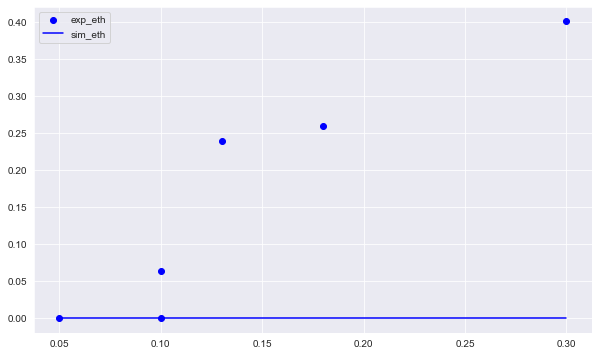

In [40]:
df = pd.DataFrame({
    'growthdata': result0[1][:,0][0:6],
    'exp_eth': result0[1][:,3][0:6],
    #'exp_CO2': result0[1][:,7][0:6],
    #'exp_O2': -result0[1][:,8][0:6],
    'sim_eth': result0[2][:,3][0:6],
    #'sim_CO2': result0[2][:,7][0:6],
    #'sim_O2': -result0[2][:,8][0:6],
})
# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(df['growthdata'], df['exp_eth'], label='exp_eth', color='blue')  # Exp as scatter points
plt.plot(df['growthdata'], df['sim_eth'], label='sim_eth', color='blue')  # Sim as line
#plt.scatter(df['growthdata'], df['exp_CO2'], label='exp_CO2', color='red')  # Exp as scatter points
#plt.plot(df['growthdata'], df['sim_CO2'], label='sim_CO2', color='red')  # Sim as line
#plt.scatter(df['growthdata'], df['exp_O2'], label='exp_O2', color='green')  # Exp as scatter points
#plt.plot(df['growthdata'], df['sim_O2'], label='sim_O2', color='green')  # Sim as line
plt.legend()
output_file_path = "F:/python/Bayesian_python_ecmodel/fluxes_result_N2.png"
plt.savefig(output_file_path, dpi=300, bbox_inches='tight', facecolor='white')
# Show the plot


In [8]:
dir3 = "data/model/emodel_Saccharomyces_cerevisiae_Posterior_mean.xml"
ecYeast2 = read_sbml_model (dir3)

In [23]:
#ecYeast = get_r_max(ecYeast,model_cobra)
ecModel.optimize().objective_value

0.08409871417746691

In [24]:
ecYeast2.optimize().objective_value

0.5687391608555893

In [28]:
metabolites1 = set([m.id for m in ecModel.metabolites])
metabolites2 = set([m.id for m in ecYeast2.metabolites])
reactions1 = set([r.id for r in ecModel.reactions])
reactions2 = set([r.id for r in ecYeast2.reactions])

# 找出只在一个模型中存在的代谢物和反应
unique_metabolites1 = metabolites1 - metabolites2
unique_metabolites2 = metabolites2 - metabolites1
unique_reactions1 = reactions1 - reactions2
unique_reactions2 = reactions2 - reactions1

# 输出结果
#print("Unique metabolites in model1:", unique_metabolites1)
#print("Unique metabolites in model2:", unique_metabolites2)
print("Unique reactions in model1:", unique_reactions1)
print("Unique reactions in model2:", unique_reactions2)

Unique reactions in model1: 5012
Unique reactions in model2: 5031


In [29]:
for rxn in ecModel.reactions:
    print(rxn)

r_0001_1No1: 4.857408016391145e-06 prot_YDL174C[c] + 9.71481603278229e-06 prot_YEL039C[c] + s_0025[c] + 2.0 s_0709[m] --> 2.0 s_0710[m] + s_1399[c]
r_0001_2No1: 6.388740882891548e-05 prot_YDL174C[c] + 0.00012777481765783097 prot_YJR048W[c] + s_0025[c] + 2.0 s_0709[m] --> 2.0 s_0710[m] + s_1399[c]
r_0001_3No1: 2.0040709471475004e-06 prot_YEL039C[c] + 1.0020354735737502e-06 prot_YEL071W[c] + s_0025[c] + 2.0 s_0709[m] --> 2.0 s_0710[m] + s_1399[c]
r_0001_4No1: 1.4696767133845993e-06 prot_YEL071W[c] + 2.9393534267691987e-06 prot_YJR048W[c] + s_0025[c] + 2.0 s_0709[m] --> 2.0 s_0710[m] + s_1399[c]
r_0002_1No1: 2.7740683174720946e-05 prot_YDL178W[c] + 5.548136634944189e-05 prot_YEL039C[c] + s_0027[m] + 2.0 s_0709[m] --> 2.0 s_0710[m] + s_1401[m]
r_0002_2No1: 0.00018094277532209148 prot_YDL178W[c] + 0.00036188555064418297 prot_YJR048W[c] + s_0027[m] + 2.0 s_0709[m] --> 2.0 s_0710[m] + s_1401[m]
r_0003_fwdNo1: 7.580186387021799e-07 prot_YAL060W[c] + s_0035[c] + s_1198[c] --> s_0020[c] + s_0794

In [36]:
ecModel = get_r_max(ecModel,model_cobra)
ecModel

D:\Anaconda\lib\site-packages\cobra\util\solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


<Solution infeasible at 0x17b155a4040>

In [30]:
for rxn in ecYeast2.reactions:
    print(rxn)

r_0001_1: 1.95082305851933e-05 YDL174C[c] + 3.90164611703866e-05 YEL039C[c] + s_0025[c] + 2.0 s_0709[m] --> 2.0 s_0710[m] + s_1399[c]
r_0001_2: 1.6525172123019e-05 YDL174C[c] + 3.30503442460381e-05 YJR048W[c] + s_0025[c] + 2.0 s_0709[m] --> 2.0 s_0710[m] + s_1399[c]
r_0001_3: 1.26712985892903e-05 YEL039C[c] + 6.33564929464513e-06 YEL071W[c] + s_0025[c] + 2.0 s_0709[m] --> 2.0 s_0710[m] + s_1399[c]
r_0001_4: 7.79271023239152e-06 YEL071W[c] + 1.5585420464783e-05 YJR048W[c] + s_0025[c] + 2.0 s_0709[m] --> 2.0 s_0710[m] + s_1399[c]
r_0002_1: 5.88594554993651e-05 YDL178W[c] + 0.00011771891099873 YEL039C[c] + s_0027[m] + 2.0 s_0709[m] --> 2.0 s_0710[m] + s_1401[m]
r_0002_2: 0.000239875257912023 YDL178W[c] + 0.000479750515824046 YJR048W[c] + s_0027[m] + 2.0 s_0709[m] --> 2.0 s_0710[m] + s_1401[m]
r_0003_fwd: 3.77557988496912e-07 YAL060W[c] + s_0035[c] + s_1198[c] --> s_0020[c] + s_0794[c] + s_1203[c]
r_0003_rvs: 3.02796229335042e-07 YAL060W[c] + s_0020[c] + s_0794[c] + s_1203[c] --> s_0035[c]

In [25]:
solution3 = DLecModelSimulate (model=ecModel , dilution_rate=0.084)
flux_max = solution3.fluxes
result = pd.DataFrame ({'rxnID': flux_max.index , 'flux': flux_max.values})
result = result[result['rxnID'].str.contains ("prot_")]
result['geneID'] = result['rxnID'].str.replace ("prot_" , "")
result[result['rxnID'].str.contains ("YLR142W")]

None


D:\Anaconda\lib\site-packages\cobra\util\solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


TypeError: unsupported operand type(s) for *: 'NoneType' and 'float'

In [22]:
    ecModel.reactions.get_by_id(idx[1]).lower_bound = -1000  # glucose uptake
    ecModel.reactions.get_by_id(idx[0]).lower_bound = dilutionrate
    ecModel.objective = {ecModel.reactions.r_1714: 1}  # minimize the uptake of glucose
    solution2 = ecModel.optimize()
    # then fix glucose uptake and minimize the protein pool
    ecModel.reactions.get_by_id(idx[1]).lower_bound = solution2.objective_value * 1.00001
    print('Glucose uptake rate: ',solution2.objective_value)
    ecModel.reactions.get_by_id(idx[9]).lower_bound = -1000 # protein pool
    ecModel.objective = {ecModel.reactions.prot_pool_exchange: 1}  # minimize the usage of protein pools
    solution_f = ecModel.optimize()
    solution_f.fluxes["prot_pool_exchange"]
    solution_f.fluxes["r_1714"]

In [35]:
#ecModel.objective = {ecModel.reactions.r_1714: 1}
#print(ecModel.objective)
#ecModel.optimize().objective_value
ecModel.reactions.get_by_any("growth")

KeyError: 'growth'

In [25]:
dir2 = "data/ecModel.xml"
#dir2 = "data/model_test.xml"
ecYeast = read_sbml_model (dir2)
# solve the model
solution3 = DLecModelSimulate (model=ecYeast , dilution_rate=0.42)
flux_max = solution3.fluxes
result = pd.DataFrame ({'rxnID': flux_max.index , 'flux': flux_max.values})
result = result[result['rxnID'].str.contains ("prot_")]
result['geneID'] = result['rxnID'].str.replace ("prot_" , "")
result[result['rxnID'].str.contains ("YLR142W")]

'' is not a valid SBML 'SId'.
D:\Anaconda\lib\site-packages\cobra\util\solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


TypeError: unsupported operand type(s) for *: 'NoneType' and 'float'

In [57]:
def DLecModelSimulate(model, dilution_rate):
   """
   This function is used to do simulation with ecModels using kcat value from deep learning.
   :param model: a ecModel
   :param dilution_rate: a dilution rate in range of 0-0.42 /h

   :return: solution_f: fluxes datasets

   """

   dilutionrate = dilution_rate
   ecYeast = model
   if dilutionrate >= 0.4:
       ecYeast.reactions.get_by_id("prot_pool_exchange").bounds = (-167.27 * dilutionrate / 0.4, 0)  # this value is further rescaled by maximal growth rate at 0.42.
   else:
       ecYeast.reactions.get_by_id("prot_pool_exchange").bounds = (-167.27, 0)  # -230/0.55*0.4, this is rescaled by maximal growth rate.

   # refer to bioRxiv
   ex_mets = ['biomass pseudoreaction', 'D-glucose exchange', 'acetate exchange', 'ethanol exchange',
              'glycerol exchange', 'pyruvate exchange', 'ethyl acetate exchange', 'carbon dioxide exchange',
              'oxygen exchange', 'prot_pool_exchange']
   # find the related rxnID
   idx = []
   for name0 in ex_mets:
       #print(name0)
       s = getRxnByReactionName(model=ecYeast, name=name0)
       if len(s) > 1:
           print("need check")
       elif len(s) == 1:
           idx.append(s[0])

   model_tmp = ecYeast.copy() # this is adjusted for the newly added constraints from organelle
   model_tmp.reactions.get_by_id(idx[1]).lower_bound = -1000  # glucose uptake
   model_tmp.reactions.get_by_id(idx[0]).lower_bound = dilutionrate
   model_tmp.objective = {model_tmp.reactions.r_1714: 1}  # minimize the uptake of glucose
   solution2 = model_tmp.optimize()
   print(solution2.objective_value)
   # then fix glucose uptake and minimize the protein pool
   model_tmp.reactions.get_by_id(idx[1]).lower_bound = solution2.objective_value * 1.00001
   print('Glucose uptake rate: ',solution2.objective_value)
   model_tmp.reactions.get_by_id(idx[9]).lower_bound = -1000 # protein pool
   model_tmp.objective = {model_tmp.reactions.prot_pool_exchange: 1}  # minimize the usage of protein pools
   solution_f = model_tmp.optimize()
   solution_f.fluxes["prot_pool_exchange"]
   solution_f.fluxes["r_1714"]
   return solution_f

In [66]:
#ecModel = get_r_max(ecModel,model_cobra)
ecModel

Name,None
Memory address,17c80181610
Number of metabolites,3874
Number of reactions,7340
Number of genes,1150
Number of groups,0
Objective expression,1.0*r_2111 - 1.0*r_2111_reverse_58b69
Compartments,"c, m, ce, er, p, n, e, erm, g, v, lp, vm, gm, mm"


In [58]:
solution_f = DLecModelSimulate(ecModel,0.084)
solution_f

D:\Anaconda\lib\site-packages\cobra\util\solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


None


TypeError: unsupported operand type(s) for *: 'NoneType' and 'float'

In [67]:
   ex_mets = ['biomass pseudoreaction', 'D-glucose exchange', 'acetate exchange', 'ethanol exchange',
              'glycerol exchange', 'pyruvate exchange', 'ethyl acetate exchange', 'carbon dioxide exchange',
              'oxygen exchange', 'prot_pool_exchange']
   # find the related rxnID
   idx = []
   for name0 in ex_mets:
       #print(name0)
       s = getRxnByReactionName(model=ecModel, name=name0)
       if len(s) > 1:
           print("need check")
       elif len(s) == 1:
           idx.append(s[0])

In [133]:
idx

['r_4041',
 'r_1714',
 'r_1634',
 'r_1761',
 'r_1808',
 'r_2033',
 'r_1765',
 'r_1672',
 'r_1992',
 'prot_pool_exchange']

In [137]:
model_tmp.reactions.r_1808

Reaction identifier,r_1808
Name,glycerol exchange
Memory address,0x17bee56a550
Stoichiometry,s_0766[e] --> glycerol [extracellular] -->
GPR,
Lower bound,0.0
Upper bound,inf


In [138]:
   #model_tmp = ecModel.copy() # this is adjusted for the newly added constraints from organelle
dilutionrate = 0.42
with ecModel as model_tmp:
    model_tmp.reactions.r_1714.lower_bound = -20
    model_tmp.reactions.r_1634.lower_bound = 0.566
    model_tmp.reactions.r_1761.lower_bound = 27
    model_tmp.reactions.r_1808.lower_bound = 1.469
    #model_tmp.reactions.get_by_id(idx[1]).lower_bound = -1000  # glucose uptake
    model_tmp.reactions.get_by_id(idx[0]).lower_bound = dilutionrate
    model_tmp.objective = {model_tmp.reactions.r_1714: 1}  # minimize the uptake of glucose
    solution2 = model_tmp.optimize()
    print(solution2.objective_value)
    # then fix glucose uptake and minimize the protein pool
    model_tmp.reactions.get_by_id(idx[1]).lower_bound = solution2.objective_value * 1.00001
    print('Glucose uptake rate: ',solution2.objective_value)
    model_tmp.reactions.get_by_id(idx[9]).lower_bound = -1000 # protein pool
    model_tmp.objective = {model_tmp.reactions.prot_pool_exchange: 1}  # minimize the usage of protein pools
    solution_f = model_tmp.optimize()
    print(solution_f.fluxes["prot_pool_exchange"])
    print(solution_f.fluxes["r_1714"])

-18.14495638866278
Glucose uptake rate:  -18.14495638866278
272.515
-18.14495638866278


In [89]:
ecModel.reactions.get_by_id("prot_pool_exchange")

Reaction identifier,prot_pool_exchange
Name,prot_pool_exchange
Memory address,0x17d5872ff10
Stoichiometry,--> prot_pool --> prot_pool
GPR,
Lower bound,0
Upper bound,272.515


In [76]:
ecModel

Name,None
Memory address,17c80181610
Number of metabolites,3874
Number of reactions,7340
Number of genes,1150
Number of groups,0
Objective expression,1.0*r_2111 - 1.0*r_2111_reverse_58b69
Compartments,"c, m, ce, er, p, n, e, erm, g, v, lp, vm, gm, mm"


In [85]:
ecModel.reactions.r_1714.lower_bound = -20

In [87]:
ecModel.optimize().objective_value

0.5544569479535119

In [2]:
dir2 = "data/emodel_Saccharomyces_cerevisiae_Posterior_mean.xml"
dir3 = "data/model_test.xml"
ecYeast1 = read_sbml_model(dir2)
ecYeast2 = read_sbml_model(dir3)

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-26


'' is not a valid SBML 'SId'.


In [12]:
ecYeast1.reactions.get_by_id("prot_YLR142W")

Reaction identifier,prot_YLR142W
Name,prot_YLR142W
Memory address,0x2a72b5680a0
Stoichiometry,53270.87 protein_pool[c] --> YLR142W[c] 53270.87 protein_pool --> YLR142W
GPR,
Lower bound,0.0
Upper bound,1000.0


In [13]:
ecModel.reactions.get_by_id("draw_prot_YLR142W")

Reaction identifier,draw_prot_YLR142W
Name,draw_prot_YLR142W
Memory address,0x298372a69a0
Stoichiometry,53270.869999999995 prot_pool --> prot_YLR142W[c] 53270.869999999995 prot_pool -->
GPR,
Lower bound,0.0
Upper bound,inf


NameError: name 'solution3' is not defined

In [10]:
for rxn in ecYeast1.reactions:
    print(rxn)

r_0001_1: 1.95082305851933e-05 YDL174C[c] + 3.90164611703866e-05 YEL039C[c] + s_0025[c] + 2.0 s_0709[m] --> 2.0 s_0710[m] + s_1399[c]
r_0001_2: 1.6525172123019e-05 YDL174C[c] + 3.30503442460381e-05 YJR048W[c] + s_0025[c] + 2.0 s_0709[m] --> 2.0 s_0710[m] + s_1399[c]
r_0001_3: 1.26712985892903e-05 YEL039C[c] + 6.33564929464513e-06 YEL071W[c] + s_0025[c] + 2.0 s_0709[m] --> 2.0 s_0710[m] + s_1399[c]
r_0001_4: 7.79271023239152e-06 YEL071W[c] + 1.5585420464783e-05 YJR048W[c] + s_0025[c] + 2.0 s_0709[m] --> 2.0 s_0710[m] + s_1399[c]
r_0002_1: 5.88594554993651e-05 YDL178W[c] + 0.00011771891099873 YEL039C[c] + s_0027[m] + 2.0 s_0709[m] --> 2.0 s_0710[m] + s_1401[m]
r_0002_2: 0.000239875257912023 YDL178W[c] + 0.000479750515824046 YJR048W[c] + s_0027[m] + 2.0 s_0709[m] --> 2.0 s_0710[m] + s_1401[m]
r_0003_fwd: 3.77557988496912e-07 YAL060W[c] + s_0035[c] + s_1198[c] --> s_0020[c] + s_0794[c] + s_1203[c]
r_0003_rvs: 3.02796229335042e-07 YAL060W[c] + s_0020[c] + s_0794[c] + s_1203[c] --> s_0035[c]

In [11]:
for rxn in ecYeast2.reactions:
    print(rxn)

r_0001_1: 2.00484852567449e-05 prot_YDL174C[c] + 4.00969705134898e-05 prot_YEL039C[c] + s_0025[c] + 2.0 s_0709[m] --> 2.0 s_0710[m] + s_1399[c]
r_0001_2: 2.00484852567449e-05 prot_YDL174C[c] + 4.00969705134898e-05 prot_YJR048W[c] + s_0025[c] + 2.0 s_0709[m] --> 2.0 s_0710[m] + s_1399[c]
r_0001_3: 1.12214629780371e-05 prot_YEL039C[c] + 5.61073148901856e-06 prot_YEL071W[c] + s_0025[c] + 2.0 s_0709[m] --> 2.0 s_0710[m] + s_1399[c]
r_0001_4: 5.61073148901856e-06 prot_YEL071W[c] + 1.12214629780371e-05 prot_YJR048W[c] + s_0025[c] + 2.0 s_0709[m] --> 2.0 s_0710[m] + s_1399[c]
r_0002_1: 3.71112595561493e-05 prot_YDL178W[c] + 7.42225191122987e-05 prot_YEL039C[c] + s_0027[m] + 2.0 s_0709[m] --> 2.0 s_0710[m] + s_1401[m]
r_0002_2: 9.12721882689682e-05 prot_YDL178W[c] + 0.000182544376537936 prot_YJR048W[c] + s_0027[m] + 2.0 s_0709[m] --> 2.0 s_0710[m] + s_1401[m]
r_0003_fwd: 1.576367452262e-07 prot_YAL060W[c] + s_0035[c] + s_1198[c] --> s_0020[c] + s_0794[c] + s_1203[c]
r_0003_rvs: 1.3364692247222

In [4]:
dir2 = "data/emodel_Saccharomyces_cerevisiae_Posterior_mean.xml"
#dir2 = "data/model_test.xml"
ecYeast = read_sbml_model(dir2)
# update the model
# manual curation 1
# rxnID = getRxnByGene(model=ecYeast, gene0='YNR016C')
target_gene0 = 'YNR016C'
rxnID0 = 'r_0109'
kcat_m0 = 8.5*3600 # unit is /h
ecYeast = updateEcGEMkcat(ecGEM=ecYeast, target_gene=target_gene0, rxnID=rxnID0, kcat_m=kcat_m0)

# manual curation 2
rxnID = getRxnByGene(model=ecYeast, gene0='YGR060W')
# using a loop
for rxn0 in rxnID:
    target_gene0 = 'YGR060W'
    kcat_m0 = 1/6.11002831284031e-05
    ecYeast = updateEcGEMkcat(ecGEM=ecYeast, target_gene=target_gene0, rxnID=rxn0, kcat_m=kcat_m0)

# save the model
cobra.io.write_sbml_model(ecYeast, "data/ecYeast_DL_update_some_kcat.xml")

Read LP format model from file C:\Users\sherr\AppData\Local\Temp\tmpobyoranf.lp
Reading time = 0.04 seconds
: 3893 rows, 14718 columns, 61468 nonzeros
old coefficient 9.39168199165235e-05 YNR016C[c]
old kcat 10647.719981243343
new coefficient 3.2679738562091506e-05 YNR016C[c]
new kcat 30600.0
old rxn: 4.69584099582617e-05 YDL141W[c] + 9.39168199165235e-05 YNR016C[c] + s_0373[c] + s_0434[c] + s_0445[c] --> s_0394[c] + s_0794[c] + s_1101[c] + s_1322[c]
new rxn: 4.69584099582617e-05 YDL141W[c] + 3.2679738562091506e-05 YNR016C[c] + s_0373[c] + s_0434[c] + s_0445[c] --> s_0394[c] + s_0794[c] + s_1101[c] + s_1322[c]
Read LP format model from file C:\Users\sherr\AppData\Local\Temp\tmp38rg7f07.lp
Reading time = 0.03 seconds
: 3893 rows, 14718 columns, 61468 nonzeros
old coefficient 0.000431221097017633 YGR060W[c]
old kcat 2318.9960020882495
new coefficient 6.11002831284031e-05 YGR060W[c]
new kcat 16366.536271173836
old rxn: 0.000431221097017633 YGR060W[c] + s_1212[c] + s_1275[c] + s_1577[c] --

In [12]:
# update the model
# manual curation 1
# rxnID = getRxnByGene(model=ecYeast, gene0='YNR016C')
target_gene0 = 'YNR016C'
rxnID0 = 'r_0109'
kcat_m0 = 8.5*3600 # unit is /h
ecYeast = updateEcGEMkcat(ecGEM=ecYeast, target_gene=target_gene0, rxnID=rxnID0, kcat_m=kcat_m0)

# manual curation 2
rxnID = getRxnByGene(model=ecYeast, gene0='YGR060W')
# using a loop
for rxn0 in rxnID:
    target_gene0 = 'YGR060W'
    kcat_m0 = 1/6.11002831284031e-05
    ecYeast = updateEcGEMkcat(ecGEM=ecYeast, target_gene=target_gene0, rxnID=rxn0, kcat_m=kcat_m0)

# save the model
cobra.io.write_sbml_model(ecYeast, "data/ecYeast_DL_update_some_kcat.xml")

Read LP format model from file C:\Users\sherr\AppData\Local\Temp\tmpspgdonbr.lp
Reading time = 0.03 seconds
: 3893 rows, 14718 columns, 61468 nonzeros
old coefficient 3.26797385620915e-05 YNR016C[c]
old kcat 30600.000000000004
new coefficient 3.2679738562091506e-05 YNR016C[c]
new kcat 30600.0
old rxn: 1.63398692810458e-05 YDL141W[c] + 3.26797385620915e-05 YNR016C[c] + s_0373[c] + s_0434[c] + s_0445[c] --> s_0394[c] + s_0794[c] + s_1101[c] + s_1322[c]
new rxn: 1.63398692810458e-05 YDL141W[c] + 3.2679738562091506e-05 YNR016C[c] + s_0373[c] + s_0434[c] + s_0445[c] --> s_0394[c] + s_0794[c] + s_1101[c] + s_1322[c]
Read LP format model from file C:\Users\sherr\AppData\Local\Temp\tmpkztj1thj.lp
Reading time = 0.03 seconds
: 3893 rows, 14718 columns, 61468 nonzeros
old coefficient 9.32515703564448e-05 YGR060W[c]
old kcat 10723.68
new coefficient 6.11002831284031e-05 YGR060W[c]
new kcat 16366.536271173836
old rxn: 9.32515703564448e-05 YGR060W[c] + s_0296[c] + s_0794[c] + s_1212[c] + s_1275[c] 

In [24]:
dir2 = "data/emodel_Saccharomyces_cerevisiae_Posterior_mean.xml"
#dir2 = "data/model_test.xml"
ecYeast = read_sbml_model(dir2)
# solve the model
solution3 = DLecModelSimulate(model=ecYeast, dilution_rate=0.42)
flux_max = solution3.fluxes
result = pd.DataFrame({'rxnID':flux_max.index, 'flux':flux_max.values})
result = result[result['rxnID'].str.contains("prot_")]
result['geneID'] = result['rxnID'].str.replace("prot_", "")

Glucose uptake rate:  -16.614752254878812


In [109]:
result

,rxnID,flux,geneID,pro_measured
6208,draw_prot_YLR146C,7.558097e-11,YLR146C,5.838022e-07
6209,draw_prot_YML075C,2.082308e-06,YML075C,6.287100e-07
6210,draw_prot_YML125C,7.453170e-08,YML125C,8.018317e-07
6211,draw_prot_YBR011C,0.000000e+00,YBR011C,3.178055e-05
6213,draw_prot_YMR041C,0.000000e+00,YMR041C,1.332596e-07
...,...,...,...,...
7334,draw_prot_YBL091C,0.000000e+00,YBL091C,2.991681e-07
7335,draw_prot_YGL256W,0.000000e+00,YGL256W,9.674271e-08
7336,draw_prot_YNL073W,0.000000e+00,YNL073W,1.597974e-08
7337,draw_prot_YOR065W,1.820044e-04,YOR065W,1.768381e-06


In [143]:
result['calculated'] = abs(((result['flux'] - result['pro_measured']) / result['pro_measured']))
filtered_df = result[result['calculated'] > 100]
filtered_df

,rxnID,flux,geneID,pro_measured,calculated
6297,draw_prot_YJL052W,0.000263,YJL052W,1.149239e-06,227.488708
6378,draw_prot_YOR347C,0.000078,YOR347C,8.854975e-08,884.382249
6547,draw_prot_YNL316C,0.000015,YNL316C,1.290906e-07,113.385924
6561,draw_prot_YLL041C,0.000061,YLL041C,5.560562e-07,108.030325
6622,draw_prot_YDR178W,0.000061,YDR178W,2.935418e-07,205.536127
6667,draw_prot_YPL134C,0.000042,YPL134C,1.489266e-07,281.071709
6705,draw_prot_YMR267W,0.000044,YMR267W,2.971246e-07,145.906216
6769,draw_prot_YLR174W,0.000015,YLR174W,1.865109e-08,816.771423
6783,draw_prot_YJR148W,0.000023,YJR148W,1.776112e-07,130.895787
6975,draw_prot_YPR021C,0.000186,YPR021C,2.802768e-08,6624.500022


In [142]:
calculated_sum = result['calculated']
calculated_sum.sum()

19065.963403350528

In [139]:
flux_max = solution_f.fluxes
result = pd.DataFrame({'rxnID':flux_max.index, 'flux':flux_max.values})
result = result[result['rxnID'].str.contains("prot_")]
result['geneID'] = result['rxnID'].str.replace("draw_prot_", "")
# input the proteomics under max growth rate
abundance_ex = pd.read_excel("data/proteomics/data_PNAS_2021.xlsx")
abundance_ex['g/gDW'] =(abundance_ex['replicate 1 (g gDW-1)']+ abundance_ex['replicate 2 (g gDW-1)']+ abundance_ex['replicate 3 (g gDW-1)'])/3
abundance_ex=abundance_ex[['Symbol','g/gDW']]
abundance_ex.columns = ['gene','g/gDW']
abundance_ex1 = splitAbundance(pro_df=abundance_ex)
# change the unit from g/gDW as mmol/gDW
# input the molecular weight
mw = pd.read_csv("data/sce_protein_weight.tsv", sep="\t")
mw = mw[["locus","proteins_molecular_weight"]]
mw.columns = ["gene name", "MW"]
mw["MW_Kda"] = mw["MW"]/1000
abundance_ex1["MW_Kda"] = singleMapping(mw["MW_Kda"], mw["gene name"], abundance_ex1["gene"])
abundance_ex_check = abundance_ex1[abundance_ex1["MW_Kda"].isna()]
abundance_ex1=abundance_ex1[~abundance_ex1["MW_Kda"].isna()]
abundance_ex1["mmol/gDW"] = abundance_ex1["g/gDW"]/abundance_ex1["MW_Kda"]# #mmol/g biomass

result['pro_measured'] = singleMapping(abundance_ex1["mmol/gDW"],abundance_ex1["gene"],result['geneID'])
result = result[~result["pro_measured"].isna()]
result.to_excel("data/data_check.xlsx")

# change the protein abundance unit from mmol/gDW into protein copy/cell
coefficient1 = 7.8298e9
result_unify = result.copy()
result_unify["pro_measured"] = result['pro_measured']*coefficient1
result_unify["flux"] = result['flux']*coefficient1

Mutiple protein have one abudance value! Need quality check.
56 gene     YBR009C; YNL030W
g/gDW            0.000348
Name: 56, dtype: object
63 gene     YPR080W; YBR118W
g/gDW            0.020647
Name: 63, dtype: object
276 gene     YKR059W; YJL138C
g/gDW            0.001259
Name: 276, dtype: object
890 gene     YOR133W; YDR385W
g/gDW            0.004732
Name: 890, dtype: object
2808 gene     YBR010W; YNL031C
g/gDW            0.000498
Name: 2808, dtype: object
Complete the quality check!


In [110]:
# input the proteomics under max growth rate
abundance_ex = pd.read_excel("data/proteomics/data_PNAS_2021.xlsx")
abundance_ex['g/gDW'] =(abundance_ex['replicate 1 (g gDW-1)']+ abundance_ex['replicate 2 (g gDW-1)']+ abundance_ex['replicate 3 (g gDW-1)'])/3
abundance_ex=abundance_ex[['Symbol','g/gDW']]
abundance_ex.columns = ['gene','g/gDW']
abundance_ex1 = splitAbundance(pro_df=abundance_ex)
# change the unit from g/gDW as mmol/gDW
# input the molecular weight
mw = pd.read_csv("data/sce_protein_weight.tsv", sep="\t")
mw = mw[["locus","proteins_molecular_weight"]]
mw.columns = ["gene name", "MW"]
mw["MW_Kda"] = mw["MW"]/1000
abundance_ex1["MW_Kda"] = singleMapping(mw["MW_Kda"], mw["gene name"], abundance_ex1["gene"])
abundance_ex_check = abundance_ex1[abundance_ex1["MW_Kda"].isna()]
abundance_ex1=abundance_ex1[~abundance_ex1["MW_Kda"].isna()]
abundance_ex1["mmol/gDW"] = abundance_ex1["g/gDW"]/abundance_ex1["MW_Kda"]# #mmol/g biomass

result['pro_measured'] = singleMapping(abundance_ex1["mmol/gDW"],abundance_ex1["gene"],result['geneID'])
result = result[~result["pro_measured"].isna()]
result.to_excel("data/data_check.xlsx")

# change the protein abundance unit from mmol/gDW into protein copy/cell
coefficient1 = 7.8298e9
result_unify = result.copy()
result_unify["pro_measured"] = result['pro_measured']*coefficient1
result_unify["flux"] = result['flux']*coefficient1

Mutiple protein have one abudance value! Need quality check.
56 gene     YBR009C; YNL030W
g/gDW            0.000348
Name: 56, dtype: object
63 gene     YPR080W; YBR118W
g/gDW            0.020647
Name: 63, dtype: object
276 gene     YKR059W; YJL138C
g/gDW            0.001259
Name: 276, dtype: object
890 gene     YOR133W; YDR385W
g/gDW            0.004732
Name: 890, dtype: object
2808 gene     YBR010W; YNL031C
g/gDW            0.000498
Name: 2808, dtype: object
Complete the quality check!


In [8]:
def DLecModelSimulate(model, dilution_rate):
   """
   This function is used to do simulation with ecModels using kcat value from deep learning.
   :param model: a ecModel
   :param dilution_rate: a dilution rate in range of 0-0.42 /h

   :return: solution_f: fluxes datasets

   """

   dilutionrate = dilution_rate
   ecYeast = model
   if dilutionrate >= 0.4:
       ecYeast.reactions.get_by_id("prot_pool_exchange").bounds = (-167.27 * dilutionrate / 0.4, 0)  # this value is further rescaled by maximal growth rate at 0.42.
   else:
       ecYeast.reactions.get_by_id("prot_pool_exchange").bounds = (-167.27, 0)  # -230/0.55*0.4, this is rescaled by maximal growth rate.

   # refer to bioRxiv
   ex_mets = ['biomass pseudoreaction', 'D-glucose exchange', 'acetate exchange', 'ethanol exchange',
              'glycerol exchange', 'pyruvate exchange', 'ethyl acetate exchange', 'carbon dioxide exchange',
              'oxygen exchange', 'prot_pool_exchange']
   # find the related rxnID
   idx = []
   for name0 in ex_mets:
       #print(name0)
       s = getRxnByReactionName(model=ecYeast, name=name0)
       if len(s) > 1:
           print("need check")
       elif len(s) == 1:
           idx.append(s[0])

   model_tmp = ecYeast #.copy() # this is adjusted for the newly added constraints from organelle
   model_tmp.reactions.get_by_id(idx[1]).lower_bound = -1000  # glucose uptake
   model_tmp.reactions.get_by_id(idx[0]).lower_bound = dilutionrate
   model_tmp.objective = {model_tmp.reactions.r_1714: 1}  # minimize the uptake of glucose
   solution2 = model_tmp.optimize()
   # then fix glucose uptake and minimize the protein pool
   model_tmp.reactions.get_by_id(idx[1]).lower_bound = solution2.objective_value * 1.00001
   print('Glucose uptake rate: ',solution2.objective_value)
   model_tmp.reactions.get_by_id(idx[9]).lower_bound = -1000 # protein pool
   model_tmp.objective = {model_tmp.reactions.prot_pool_exchange: 1}  # minimize the usage of protein pools
   solution_f = model_tmp.optimize()
   solution_f.fluxes["prot_pool_exchange"]
   solution_f.fluxes["r_1714"]
   return solution_f

,rxnID,flux,geneID,pro_measured
6208,prot_YDL174C,0.000000,YDL174C,10790.410975
6210,prot_YJR048W,302127.486284,YJR048W,38148.733123
6211,prot_YEL071W,0.000000,YEL071W,118873.191534
6212,prot_YDL178W,0.000000,YDL178W,5769.674059
6213,prot_YAL060W,0.000000,YAL060W,9088.459261
...,...,...,...,...
7350,prot_YOL122C,290.471375,YOL122C,1190.981051
7352,prot_YGL255W,40.241999,YGL255W,103012.144945
7353,prot_YLR130C,0.000000,YLR130C,5526.970128
7354,prot_YOL130W,0.000000,YOL130W,840.551908


In [19]:
def DLecModelSimulate(model, dilution_rate):
   """
   This function is used to do simulation with ecModels using kcat value from deep learning.
   :param model: a ecModel
   :param dilution_rate: a dilution rate in range of 0-0.42 /h

   :return: solution_f: fluxes datasets

   """

   dilutionrate = dilution_rate
   ecYeast = model
   if dilutionrate >= 0.4:
       ecYeast.reactions.get_by_id("EX_protein_pool").bounds = (-167.27 * dilutionrate / 0.4, 0)  # this value is further rescaled by maximal growth rate at 0.42.
   else:
       ecYeast.reactions.get_by_id("EX_protein_pool").bounds = (-167.27, 0)  # -230/0.55*0.4, this is rescaled by maximal growth rate.

   # refer to bioRxiv
   ex_mets = ['biomass pseudoreaction', 'D-glucose exchange', 'acetate exchange', 'ethanol exchange',
              'glycerol exchange', 'pyruvate exchange', 'ethyl acetate exchange', 'carbon dioxide exchange',
              'oxygen exchange', 'EX_protein_pool']
   # find the related rxnID
   idx = []
   for name0 in ex_mets:
       #print(name0)
       s = getRxnByReactionName(model=ecYeast, name=name0)
       if len(s) > 1:
           print("need check")
       elif len(s) == 1:
           idx.append(s[0])

   model_tmp = ecYeast #.copy() # this is adjusted for the newly added constraints from organelle
   model_tmp.reactions.get_by_id(idx[1]).lower_bound = -1000  # glucose uptake
   model_tmp.reactions.get_by_id(idx[0]).lower_bound = dilutionrate
   model_tmp.objective = {model_tmp.reactions.r_1714: 1}  # minimize the uptake of glucose
   solution2 = model_tmp.optimize()
   # then fix glucose uptake and minimize the protein pool
   model_tmp.reactions.get_by_id(idx[1]).lower_bound = solution2.objective_value * 1.00001
   print('Glucose uptake rate: ',solution2.objective_value)
   model_tmp.reactions.get_by_id(idx[9]).lower_bound = -1000 # protein pool
   model_tmp.objective = {model_tmp.reactions.EX_protein_pool: 1}  # minimize the usage of protein pools
   solution_f = model_tmp.optimize()
   solution_f.fluxes["EX_protein_pool"]
   solution_f.fluxes["r_1714"]
   return solution_f

Correlation coefficient: 0.3912010612995356
Correlation p_value: 1.3820287872895714e-13


D:\Anaconda\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Text(0, 0.5, 'Predicted_protein_copy/cell')

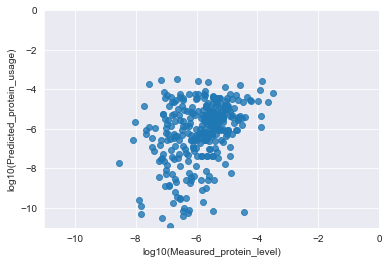

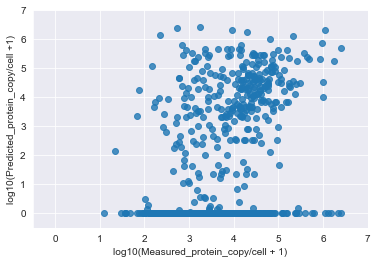

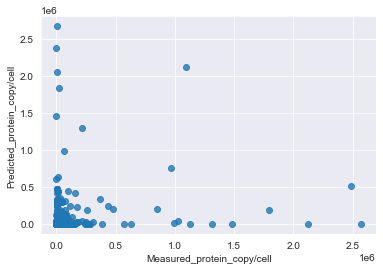

In [140]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr

# method1 absolute protein abundance mmol protein/gDW
plt.figure()
sns.regplot(x=np.log10(result['pro_measured']), y=np.log10(result['flux']), fit_reg=False)
plt.xlim(-11, 0)
plt.ylim(-11, 0)
plt.xlabel("log10(Measured_protein_level)")
plt.ylabel("log10(Predicted_protein_usage)")

from scipy.stats import pearsonr
result1 = result[result['flux'] > 0]
result1 = result1[result1['pro_measured'] > 0]
corr, ss = pearsonr(np.log10(result1['pro_measured']), np.log10(result1['flux']))
print("Correlation coefficient:", corr)
print("Correlation p_value:", ss)


# method2 protein copy/cell
plt.figure()
sns.regplot(x=np.log10(result_unify['pro_measured']+1), y=np.log10(result_unify['flux']+1), fit_reg=False)
plt.xlim(-0.5, 7)
plt.ylim(-0.5, 7)
plt.xlabel("log10(Measured_protein_copy/cell + 1)")
plt.ylabel("log10(Predicted_protein_copy/cell +1)")

plt.figure()
sns.regplot(x=result_unify['pro_measured'], y=result_unify['flux'], fit_reg=False)
plt.xlabel("Measured_protein_copy/cell")
plt.ylabel("Predicted_protein_copy/cell")

In [105]:
result

,rxnID,flux,geneID,pro_measured
